1. Import Libraries and Loading Dataset

In [ ]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 


import plotly.express as px
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor



%matplotlib inline

2. Exploratory Data Analysis

In [ ]:
data_dir = "/content/drive/MyDrive/zillow-prize-1"
#Read Property Information from 2016 and 2017
properties_2016 = pd.read_csv( data_dir +"/properties_2016.csv", low_memory=False)
properties_2017 = pd.read_csv( data_dir +"/properties_2017.csv", low_memory=False)
#Read Training Information
data_2016  = pd.read_csv( data_dir +"/train_2016_v2.csv", low_memory=False,parse_dates=['transactiondate'])
data_2017  = pd.read_csv( data_dir +"/train_2017.csv", low_memory=False,parse_dates=['transactiondate'])
# Read Submission Data
submission_data = pd.read_csv(data_dir+'/sample_submission.csv', low_memory = False)

In [ ]:
#merge training with properties
train_2016 = pd.merge(data_2016, properties_2016, how = 'left', on = 'parcelid').copy()
train_2017 = pd.merge(data_2017, properties_2017, how = 'left', on = 'parcelid').copy()
#traindata_2016.describe()
#traindata_2017.describe()

train_df = pd.concat([train_2016,train_2017],axis=0)
train_df

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.168400,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.004000,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.021800,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.005000,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
77609,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
77610,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
77611,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13


In [ ]:
test_df = pd.merge(submission_data[['ParcelId']], properties_2016.rename(columns = {'parcelid': 'ParcelId'}), how = 'left', on = 'ParcelId')
test_df['transactiondate'] = pd.Timestamp('2016-12-01') 
test_df

,ParcelId,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,transactiondate
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,2016-12-01
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,2016-12-01
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN,2016-12-01
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN,2016-12-01
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN,2016-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-01
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-01
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-01
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-01


Exploratory Data Analysis

In [ ]:
print(train_df.shape)
print(test_df.shape)

(167888, 60)
(2985217, 59)


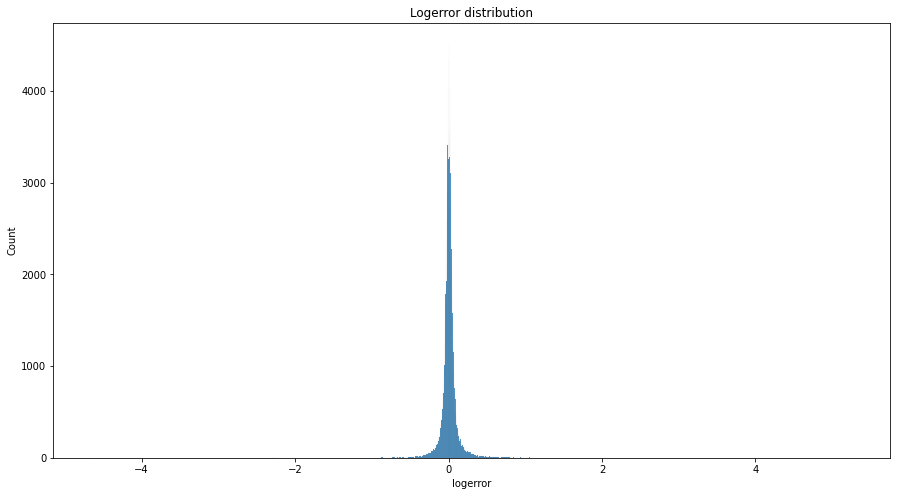

In [ ]:
#print logerror distribution
plt.figure(figsize=(15,8))
sns.histplot(train_df['logerror']).set_title("Logerror distribution");

In [ ]:
train_df.dtypes

parcelid                                 int64
logerror                               float64
transactiondate                 datetime64[ns]
airconditioningtypeid                  float64
architecturalstyletypeid               float64
basementsqft                           float64
bathroomcnt                            float64
bedroomcnt                             float64
buildingclasstypeid                    float64
buildingqualitytypeid                  float64
calculatedbathnbr                      float64
decktypeid                             float64
finishedfloor1squarefeet               float64
calculatedfinishedsquarefeet           float64
finishedsquarefeet12                   float64
finishedsquarefeet13                   float64
finishedsquarefeet15                   float64
finishedsquarefeet50                   float64
finishedsquarefeet6                    float64
fips                                   float64
fireplacecnt                           float64
fullbathcnt  

In [ ]:
test_df.dtypes

ParcelId                                 int64
airconditioningtypeid                  float64
architecturalstyletypeid               float64
basementsqft                           float64
bathroomcnt                            float64
bedroomcnt                             float64
buildingclasstypeid                    float64
buildingqualitytypeid                  float64
calculatedbathnbr                      float64
decktypeid                             float64
finishedfloor1squarefeet               float64
calculatedfinishedsquarefeet           float64
finishedsquarefeet12                   float64
finishedsquarefeet13                   float64
finishedsquarefeet15                   float64
finishedsquarefeet50                   float64
finishedsquarefeet6                    float64
fips                                   float64
fireplacecnt                           float64
fullbathcnt                            float64
garagecarcnt                           float64
garagetotalsq

In [ ]:
number_Encoded_Data = ["airconditioningtypeid", "architecturalstyletypeid","buildingclasstypeid", "heatingorsystemtypeid", "propertylandusetypeid", "storytypeid", "typeconstructiontypeid"]
print(len(number_Encoded_Data),number_Encoded_Data)

categorical = []
for col in train_df.columns:
  if train_df[col].dtypes in ['object']:
    categorical.append(col)
print(len(categorical),categorical)

continues_data=[]
for col in train_df.columns:
  if train_df[col].dtypes in ['int64','float64'] and col not in number_Encoded_Data:
    continues_data.append(col)
print(len(continues_data),continues_data)

7 ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'storytypeid', 'typeconstructiontypeid']
5 ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']
47 ['parcelid', 'logerror', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstori

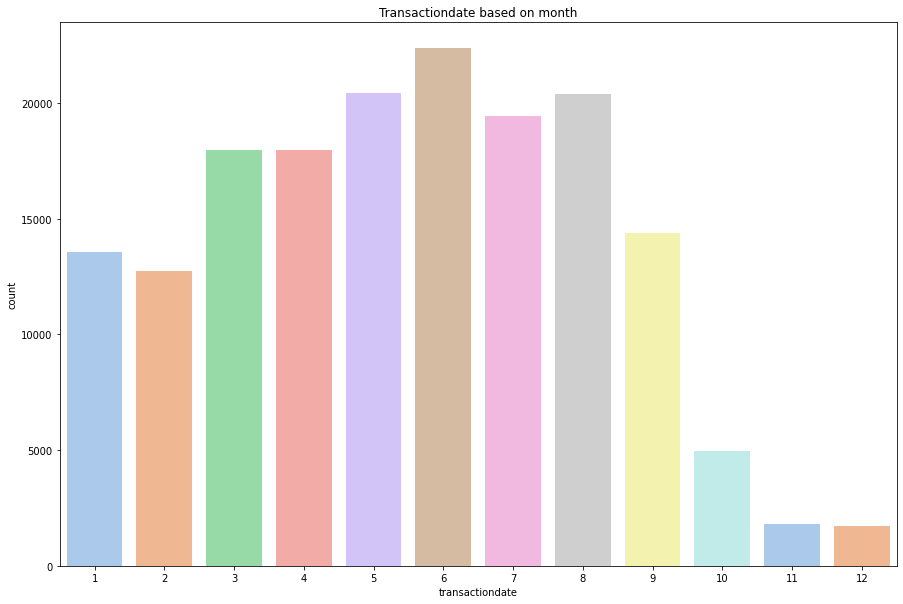

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(x=train_df["transactiondate"].dt.month,palette="pastel").set_title("Transactiondate based on month");

3. Data Cleaning and Preparation


In [ ]:
print(train_df.shape)
print(test_df.shape)
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)
print(train_df.shape)
print(test_df.shape)

(167888, 60)
(2985217, 59)
(167888, 60)
(2985217, 59)


In [ ]:
def clean_data(data):
  dataframe = data.copy()

  empty_pool_index = dataframe[dataframe["poolcnt"]==0].index
  dataframe.loc[empty_pool_index,'poolsizesum'] = 0

  pool_index = dataframe[(dataframe['poolcnt'] > 0) & (dataframe['poolsizesum'].isnull())].index
  dataframe.loc[pool_index,'poolsizesum'] = np.nan

  bad_index = dataframe[dataframe.unitcnt.isnull()].index   
  dataframe.loc[bad_index,'unitcnt'] = 1

  dataframe['fireplacecnt'] = np.where(dataframe['fireplacecnt'].isnull(),0,1)

  dataframe['decktypeid'] = np.where(dataframe['decktypeid'].isnull(),0,1)

  dataframe['taxdelinquencyflag'] = np.where(dataframe['taxdelinquencyflag']=='',0,1)

  dataframe['hashottuborspa'] = np.where(dataframe['hashottuborspa']=='',0,1)
  
  dataframe['airconditioningtypeid'] = np.where((dataframe["airconditioningtypeid"].isnull()) & (dataframe.heatingorsystemtypeid==2),1,dataframe["airconditioningtypeid"])

  dataframe.loc[dataframe[dataframe["heatingorsystemtypeid"].isnull()].index,'heatingorsystemtypeid']=0


  invalid_garages = dataframe.loc[dataframe['calculatedfinishedsquarefeet']<dataframe['finishedfloor1squarefeet']].index
  dataframe.loc[invalid_garages,'finishedfloor1squarefeet'] = np.nan

  garage_index = dataframe[(dataframe.garagecarcnt==0) & (dataframe['garagetotalsqft']>0)].index
  dataframe.loc[garage_index,'garagecarcnt'] = np.nan

  bad_index = dataframe[dataframe['taxvaluedollarcnt'].isnull()].index
  dataframe.loc[bad_index,'taxvaluedollarcnt'] = dataframe.loc[bad_index,'structuretaxvaluedollarcnt'] + dataframe.loc[bad_index,'landtaxvaluedollarcnt']
  
  return dataframe


In [ ]:
train_df = clean_data(train_df)
test_df = clean_data(test_df)


In [ ]:
percent_missing = train_df.isnull().sum() * 100 / len(train_df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
missing_value_df

,percent_missing
buildingclasstypeid,99.981535
finishedsquarefeet13,99.955327
basementsqft,99.944606
storytypeid,99.944606
yardbuildingsqft26,99.901720
fireplaceflag,99.765320
architecturalstyletypeid,99.721243
typeconstructiontypeid,99.689078
finishedsquarefeet6,99.519322
poolsizesum,99.093443


In [ ]:
# Example: 100 means 100 % of the data is missing while 20 means 20% of the data is missing
fig = px.bar(missing_value_df,x=missing_value_df.index.values, y=missing_value_df.percent_missing,title='Missing Information')
fig.show()

In [ ]:
columns_to_drop = []
columns_to_keep = []
for index, row in missing_value_df.iterrows():
    if(row['percent_missing']>90):
      columns_to_drop.append(index)
    else:
      columns_to_keep.append(index)


print("Columns to Drop",len(columns_to_drop),columns_to_drop)
print("Columns to Keep",len(columns_to_keep),columns_to_keep)

Columns to Drop 17 ['buildingclasstypeid', 'finishedsquarefeet13', 'basementsqft', 'storytypeid', 'yardbuildingsqft26', 'fireplaceflag', 'architecturalstyletypeid', 'typeconstructiontypeid', 'finishedsquarefeet6', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'taxdelinquencyyear', 'yardbuildingsqft17', 'finishedsquarefeet15', 'finishedfloor1squarefeet', 'finishedsquarefeet50']
Columns to Keep 43 ['threequarterbathnbr', 'pooltypeid7', 'poolcnt', 'numberofstories', 'garagecarcnt', 'garagetotalsqft', 'regionidneighborhood', 'airconditioningtypeid', 'buildingqualitytypeid', 'propertyzoningdesc', 'lotsizesquarefeet', 'finishedsquarefeet12', 'regionidcity', 'fullbathcnt', 'calculatedbathnbr', 'yearbuilt', 'calculatedfinishedsquarefeet', 'censustractandblock', 'structuretaxvaluedollarcnt', 'regionidzip', 'taxamount', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'propertycountylandusecode', 'bathroomcnt', 'bedroomcnt', 'assessmentyear', 'fips', 'propertylandusetypeid', 'latitude', 'roomcnt', 

In [ ]:
def drop_columns(columns_to_drop,train_df,test_df):
  train_df = train_df.drop(columns_to_drop,axis=1)
  test_df = test_df.drop(columns_to_drop,axis=1)

  return train_df,test_df

In [ ]:
print(train_df.shape)
print(test_df.shape)
train_filtered,test_filtered = drop_columns(columns_to_drop,train_df,test_df)
print(train_filtered.shape)
print(test_filtered.shape)

(167888, 60)
(2985217, 59)
(167888, 43)
(2985217, 42)


4. Splitting Data for Training Data

In [ ]:
def split_data(df,test_size,random_state):  
  valid_size = int (0.8 *(len(df)))
  df['year'] = df['transactiondate'].dt.year
  df_train, df_valid = train_test_split(df, test_size=test_size, random_state=random_state)
  return df_train,df_valid

In [ ]:
test_size = 0.3
random_state = 0

train, valid = split_data(train_filtered,test_size,random_state)
print("Training Data", train.shape)
print("Validation Data",valid.shape)

Training Data (117521, 44)
Validation Data (50367, 44)


In [ ]:
train

,parcelid,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,...,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,year
16051,14295686,0.037300,2016-03-14,NaN,2.0,2.0,NaN,2.0,0,1576.0,...,1964.0,3.0,92000.0,856783.0,2015.0,764783.0,9476.80,1,6.059063e+13,2016
76201,12450041,0.030328,2017-09-13,1.0,2.0,2.0,6.0,2.0,0,857.0,...,1972.0,NaN,101525.0,192897.0,2016.0,91372.0,2414.57,1,6.037570e+13,2017
76788,12492855,0.275809,2017-09-15,NaN,2.0,4.0,6.0,2.0,0,2055.0,...,1954.0,NaN,161681.0,404210.0,2016.0,242529.0,5056.01,1,6.037574e+13,2017
35712,11726545,-0.179144,2017-05-12,NaN,2.0,5.0,5.0,2.0,0,1560.0,...,1926.0,NaN,119097.0,410067.0,2016.0,290970.0,5080.06,1,6.037220e+13,2017
11502,10982637,0.013900,2016-02-24,1.0,3.0,4.0,4.0,3.0,0,2515.0,...,2007.0,NaN,197524.0,365785.0,2015.0,168261.0,4549.72,1,6.037104e+13,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7364,17057451,0.047255,2017-02-01,NaN,3.0,3.0,NaN,3.0,0,1758.0,...,1976.0,1.0,128364.0,143936.0,2016.0,15572.0,2495.88,1,6.111001e+13,2017
5664,11517081,-0.173370,2017-01-26,1.0,2.0,3.0,6.0,2.0,0,1403.0,...,1954.0,NaN,784173.0,950166.0,2016.0,165993.0,11354.86,1,6.037703e+13,2017
62040,11632933,0.013071,2017-07-28,1.0,3.0,2.0,7.0,3.0,0,1360.0,...,1990.0,NaN,278101.0,397283.0,2016.0,119182.0,4943.02,1,6.037700e+13,2017
27677,13923620,-0.032269,2017-04-19,NaN,2.0,4.0,NaN,2.0,0,1760.0,...,1955.0,1.0,50638.0,77039.0,2016.0,26401.0,1128.30,1,6.059086e+13,2017


In [ ]:
valid

,parcelid,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,...,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,year
90220,11664183,0.002000,2016-12-30,1.0,3.0,2.0,10.0,3.0,0,1881.0,...,2000.0,NaN,340972.0,841985.0,2015.0,501013.0,10264.07,1,6.037263e+13,2016
72822,11694990,-0.866635,2017-08-31,NaN,1.0,2.0,5.0,1.0,0,1324.0,...,1912.0,NaN,31193.0,168458.0,2016.0,137265.0,2098.18,1,6.037232e+13,2017
77419,12808835,0.058076,2017-09-19,NaN,2.0,3.0,4.0,2.0,0,1116.0,...,1955.0,NaN,110241.0,283826.0,2016.0,173585.0,3554.26,1,6.037407e+13,2017
7317,11611721,-0.032227,2017-02-01,1.0,2.0,3.0,8.0,2.0,0,1614.0,...,1929.0,NaN,48645.0,125874.0,2016.0,77229.0,16893.75,1,6.037268e+13,2017
65395,12189307,0.043831,2017-08-10,NaN,2.0,3.0,4.0,2.0,0,1512.0,...,1922.0,NaN,63911.0,78380.0,2016.0,14469.0,1029.70,1,6.037239e+13,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21452,10971072,0.013900,2016-03-31,1.0,2.0,4.0,7.0,2.0,0,1785.0,...,1955.0,NaN,96046.0,255839.0,2015.0,159793.0,3182.77,1,6.037106e+13,2016
67050,14469180,-0.006000,2016-08-17,NaN,3.0,4.0,NaN,3.0,0,3163.0,...,1997.0,NaN,416661.0,510598.0,2015.0,93937.0,7363.00,1,6.059032e+13,2016
46819,14245124,0.068798,2017-06-15,1.0,3.0,4.0,NaN,3.0,0,3127.0,...,1957.0,NaN,277458.0,885139.0,2016.0,607681.0,9955.76,1,6.059076e+13,2017
41075,14708643,0.012724,2017-05-30,NaN,1.0,2.0,NaN,1.0,0,845.0,...,1972.0,NaN,58725.0,208000.0,2016.0,149275.0,2602.94,1,6.059012e+13,2017


In [ ]:
test_filtered

,ParcelId,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,transactiondate
0,10754147,NaN,0.0,0.0,NaN,NaN,0,NaN,NaN,6037.0,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,1,NaN,2016-12-01
1,10759547,NaN,0.0,0.0,NaN,NaN,0,NaN,NaN,6037.0,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,1,NaN,2016-12-01
2,10843547,NaN,0.0,0.0,NaN,NaN,0,73026.0,NaN,6037.0,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,1,NaN,2016-12-01
3,10859147,NaN,0.0,0.0,7.0,NaN,0,5068.0,NaN,6037.0,...,1948.0,1.0,571346.0,1156834.0,2015.0,585488.0,14557.57,1,NaN,2016-12-01
4,10879947,NaN,0.0,0.0,NaN,NaN,0,1776.0,NaN,6037.0,...,1947.0,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,1,NaN,2016-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2016-12-01
2985213,14273630,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2016-12-01
2985214,168040630,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2016-12-01
2985215,168040830,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2016-12-01


5. Model Training

6. Feature Engineering and Feature Selection

7. Data Preprocessing

8. Robust Model Training and Hyperparameter Tuning

9. Conclusion